In [31]:
import torch
import torch.nn as nn
import torch.optim as optim


from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, transforms

import numpy as np
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()

In [11]:
dataset_dir = './Dataset/'
batch_size = 4
epochs = 10

In [3]:
class YouTubePose(Dataset):
    
    def __init__(self, datapoint_pairs, dataset_dir, transform=None, mode='train'):
        self.datapoint_pairs = datapoint_pairs
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.mode = mode
    
    def __len__(self):
        return len(self.datapoint_pairs)
    
    def __getitem__(self, idx):
        image_pair = self.datapoint_pairs[idx]
        x_path = image_pair[0]
        y_path = image_pair[1]
        x = Image.open(self.dataset_dir + self.mode + '/' + x_path)
        y = Image.open(self.dataset_dir + self.mode + '/' + y_path)
        
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
            
        sample = {'x' : x, 'y': y}
        return sample

In [4]:
with open('train_datapoint_pairs.pkl', 'rb') as f:
    datapoint_pairs = pickle.load(f)

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [27]:
train_dataset = YouTubePose(datapoint_pairs, dataset_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                             num_workers=0)

0 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
1 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
2 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
3 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


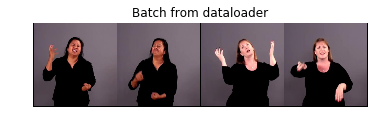

In [28]:
def show_landmarks_batch(sample_batched):
    
    images_batch, landmarks_batch = sample_batched['x'], sample_batched['y']
#     batch_size = len(images_batch)
#     im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    grid1 = utils.make_grid(landmarks_batch)
    
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
#     plt.imshow(grid1.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')
    
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['x'].size(), sample_batched['y'].size())
    
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [32]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class UpsampleConvLayer(nn.Module):
      def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
          super(UpsampleConvLayer, self).__init__()
          self.upsample = upsample
          if upsample:
              self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
          reflection_padding = kernel_size // 2
          self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
          self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

      def forward(self, x):
          x_in = x
          if self.upsample:
              x_in = self.upsample_layer(x_in)
          out = self.reflection_pad(x_in)
          out = self.conv2d(out)
          return out

In [ ]:
class Generator(nn.Module):
    def __init__(self, block):
        super(Generator, self).__init__()
        
        self.conv1_x = nn.Conv2d(3, 64)
        self.conv2_x = nn.Conv2d(64, 128)
        self.conv3_x = nn.Conv2d(128, 1)

        self.conv1_y = nn.Conv2d(3, 64)
        self.conv2_y = nn.Conv2d(64, 128)
        self.conv3_y = nn.Conv2d(128, 1)

        
#         self.avgpool = nn.AvgPool2d(2)
        
        self.block1_x = self.make_layer(block, 1, 64)
        self.block2_x = self.make_layer(block, 64, 1)
        
        self.block1_y = self.make_layer(block, 1, 64)
        self.block2_y = self.make_layer(block, 64, 1)
        
        self.block1_concat = self.make_layer(block, 1, 64)
        self.block2_concat = self.make_layer(block, 64, 1)
        
        self.deconv1 = nn.ConvTranspose2d(1, 64)
        self.deconv2 = nn.ConvTranspose2d(64, 3)
        
        def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
        
        